In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import math

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns',50)

In [3]:
data = pd.read_csv(r"C:\Users\s5030\Desktop\train.csv")
data = data.drop(["policy_id"],axis=1)
data

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
58589,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
58590,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [4]:
for i in data.columns:
    if data[i].dtype == "object":
        diff_class = list(data[i].unique())
        index = list(range(len(diff_class)))
        data[i].replace(diff_class,index,inplace=True)
    if data[i].dtype == "float":
        data[i] = pd.qcut(data[i],4,labels=[0,1,2,3])
    if data[i].dtype == "category":
        data[i] = data[i].astype(int)

In [5]:
def train_test_split(data,test_size):
    split_size = round(len(data) * test_size)
    train_feat,train_label = data.iloc[:split_size,:-1],data.iloc[:split_size,-1]
    test_feat,test_label = data.iloc[split_size+1:,:-1],data.iloc[split_size+1:,-1]
    return train_feat,train_label,test_feat,test_label

In [6]:
train_feat, train_label, test_feat, test_label = train_test_split(data,test_size=0.8)

In [7]:
train_label

0        0
1        0
2        0
3        0
4        0
        ..
46869    0
46870    0
46871    0
46872    0
46873    0
Name: is_claim, Length: 46874, dtype: int64

# Classification task

In [8]:
# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

## Naive Bayes Classifier


參考來源 : [Naive-Bayes](https://medium.com/@rangavamsi5/na%C3%AFve-bayes-algorithm-implementation-from-scratch-in-python-7b2cc39268b9)

In [9]:
class naive_bayes:
    def __init__(self):

        self.prior = {}
        self.condition_prob = {}
        
    def fit(self,feature,label):
        self.x, self.y = feature,label
        
        for feat in self.x.columns:
            self.condition_prob[feat] = {}
            
        self.cal_prior()
        self.cal_condition_prob()

    def cal_prior(self):
        self.prior = dict(self.y.value_counts()/len(self.y))

    def cal_condition_prob(self):
        for feat in self.x:
            for j in self.y.unique():
                condition_prob = dict(self.x[feat][self.y[self.y==j].index.values.tolist()].value_counts()/len(self.y[self.y==0]))
                for value,prob in condition_prob.items():
                    self.condition_prob[feat][str(value) + "_" + str(j)] = prob
            
    def predict(self,feature):
        feature = np.array(feature)
        results = []
        
        for row in feature:
            probs = []
            for j in self.y.unique():
                prior = self.prior[j]
                condition_prob = 1

                for feat, feat_value in zip(self.x.columns,row):
                    condition_prob *= self.condition_prob[feat][str(feat_value) + "_" + str(j)]
                
                posterior = prior * condition_prob
                probs.append(posterior)
            
            result = np.argmax(probs)
            results.append(result)
        return(results)



In [10]:
nbc = naive_bayes()
nbc.fit(train_feat,train_label)
pred = nbc.predict(test_feat)
print("===Confusion Matrix===")
print(confusion_matrix(test_label,pred))
print("Accuracy:{}".format(accuracy_score(test_label,pred)))
print("Recall:{}".format(recall_score(test_label,pred)))
print("f1 score:{}".format(f1_score(test_label,pred,average="macro")))

===Confusion Matrix===
[[10975     0]
 [  742     0]]
Accuracy:0.9366732098660067
Recall:0.0
f1 score:0.4836506257711969


## Random Forest Classifier(未完成 : 在tree的深度超過1與後續的Cross-Validation時會Error，因此只參與第一個實驗)

參考來源 : [Decision Tree](https://www.youtube.com/watch?v=NxEHSAfFlK8) , [Random Forest](https://www.youtube.com/watch?v=kFwe2ZZU7yw)



In [11]:
# 建立node class,用於表示決策樹節點,初始值為None
# is_leaf : 判斷此節點是否為leaf node,輸出為true or false
class Node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.right = right
        self.left = left
        self.value = value
        
    def is_leaf(self):
        return self.value is not None

In [12]:
class decision_tree:
    def __init__(self,min_sample_split,max_depth,n_features=None):
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self,x,y): # fit the data
        if self.n_features is None:
            self.n_features = x.shape[1]
        self.root = self.construct_tree(x,y)

    def construct_tree(self,x,y,depth=0):
        n_samples, n_feats = x.shape
        n_labels = len(np.unique(y))

        if(depth >= self.max_depth or n_labels == 1 or n_samples < self.min_sample_split):
            leaf_label = self.common_label(y)
            return Node(value=leaf_label)
        
        feature_index = np.random.choice(n_feats, self.n_features, replace=False)
        best_split, best_threshold = self.best_split(x,y,feature_index)
        left_index, right_index = self.split(x[:,best_split],best_threshold)

        # recursion here
        left = self.construct_tree(x[left_index,:],y[left_index],depth+1)
        right = self.construct_tree(x[right_index,:],y[right_index],depth+1)

        return Node(best_split,best_threshold,left,right)

    def best_split(self,x,y,features): # find best split feature and the threshold
        best_information_gain = -100
        split_index, split_threshold = None, None

        for feature in features:
            x_column = x[:,feature]
            thresholds = np.unique(x_column)

            for threshold in thresholds:
                gain = self.information_gain(feature,y,threshold)

                if gain > best_information_gain:
                    best_information_gain = gain
                    split_index = feature
                    split_threshold = threshold
                    
        return split_index, split_threshold

    def split(self,x_column,threshold): # collect the index that data less than threshold and larger than threshold
        left_index = np.argwhere(x_column == threshold).flatten()
        right_index = np.argwhere(x_column != threshold).flatten()
        return left_index, right_index
    
    def common_label(self,y): # calculate the most class in leaf
        counter = Counter(y) 
        value = counter.most_common(1)[0][0]
        return value

    def information_gain(self,x,y,threshold):
        before_entropy = self.entropy(y)
        left_index, right_index = self.split(x,threshold)
        if len(left_index) == 0 or len(right_index) == 0:
            return 0
        n_left, n_right = len(left_index), len(right_index)
        entropy_left, entropy_right = self.entropy(y[left_index]), self.entropy(y[right_index])
        info_gain = before_entropy - (n_left/len(y)) * entropy_left - (n_right/len(y)) * entropy_right
        return info_gain

    def entropy(self,y):
        each_label_prob = list(np.unique(y,return_counts=True)[1]/len(y))
        return -np.sum([p * math.log2(p) for p in each_label_prob if p > 0])
        
    def predict(self,x):
        x = x.values
        pred = np.array([self.traverse(feat,self.root) for feat in x])
        return pred
            
    def traverse(self,x,node):
        if node.is_leaf():
            return node.value
        if x[node.feature] == node.threshold:
            return self.traverse(x,node.left)
        
        return self.traverse(x,node.right)

In [13]:
class random_forest:
    def __init__(self,n_trees=10,max_depth=1,min_sample_split=2,n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.n_features = n_features
        self.tree_list = []
    
    def fit(self,x,y):
        x = x.values
        y = y.values
        self.tree_list = []
        for i in range(self.n_trees):
            tree = decision_tree(max_depth=self.max_depth,min_sample_split=self.min_sample_split,n_features=self.n_features)
            x_sample, y_sample = self.bootstrap(x,y)
            tree.fit(x_sample,y_sample)
            self.tree_list.append(tree)

    def bootstrap(self,x,y):
        n_samples = x.shape[0]
        sample_index = np.random.choice(n_samples,n_samples,replace=True)
        return x[sample_index], y[sample_index]
    
    def predict(self,x):
        prediction = np.array([tree.predict(x) for tree in self.tree_list])
        tree_pred = np.swapaxes(prediction,0,1)
        prediction = np.array([self.common_label(pred) for pred in tree_pred])
        return pred

    def common_label(self,y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value


In [14]:
rfc = random_forest()
rfc.fit(train_feat,train_label)

In [15]:
pred = rfc.predict(test_feat)
print("=== Confusion Matrix ===")
print(confusion_matrix(test_label,pred))
print("Accuracy:{}".format(accuracy_score(test_label,pred)))
print("Recall:{}".format(recall_score(test_label,pred)))
print("f1 score:{}".format(f1_score(test_label,pred,average="macro")))

=== Confusion Matrix ===
[[10975     0]
 [  742     0]]
Accuracy:0.9366732098660067
Recall:0.0
f1 score:0.4836506257711969


## Random Forest Classifier with sklearn

In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc_sk = RandomForestClassifier(n_estimators=100,min_samples_split=2,max_features="sqrt")
rfc_sk.fit(train_feat,train_label)
pred = rfc_sk.predict(test_feat)
print("===Confusion Matrix===")
print(confusion_matrix(test_label,pred))
print("Accuracy:{}".format(accuracy_score(test_label,pred)))
print("Recall:{}".format(recall_score(test_label,pred)))
print("f1 score:{}".format(f1_score(test_label,pred,average="macro")))

===Confusion Matrix===
[[10916    59]
 [  738     4]]
Accuracy:0.9319791755568831
Recall:0.005390835579514825
f1 score:0.4873587978268967


## XGBoost,Catboost,LightGBM

In [17]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [18]:
models = {"XGBoost":XGBClassifier(),
          "CatBoost":CatBoostClassifier(verbose=False),
          "LightGBM":LGBMClassifier()}

In [19]:
for mod, model in models.items():
    print(mod)
    model.fit(train_feat,train_label)
    pred = model.predict(test_feat)
    print("=== Confusion Matrix ===")
    print(confusion_matrix(test_label,pred))
    print("Accuracy:{}".format(accuracy_score(test_label,pred)))
    print("Recall:{}".format(recall_score(test_label,pred)))
    print("f1 score:{}".format(f1_score(test_label,pred,average="macro")))

XGBoost
=== Confusion Matrix ===
[[10965    10]
 [  742     0]]
Accuracy:0.9358197490825296
Recall:0.0
f1 score:0.483422978573318
CatBoost
=== Confusion Matrix ===
[[10971     4]
 [  742     0]]
Accuracy:0.9363318255526158
Recall:0.0
f1 score:0.48355959097320167
LightGBM
=== Confusion Matrix ===
[[10975     0]
 [  742     0]]
Accuracy:0.9366732098660067
Recall:0.0
f1 score:0.4836506257711969


# Cross-Validation

## Set k=3,5,10

In [20]:
def cross_validation(model,data,label,k):
    # construct each fold
    each_val_data = {}
    for i in range(k):
        each_val_data[str(i+1)+"-"+"fold"] = {}
        test_data = data.iloc[int(round((i/k)*len(data))) : int(round(((i+1)/k)*len(data))),:]
        train_data = data.drop(test_data.index) 
        each_val_data[str(i+1)+"-"+"fold"]["train"] = train_data
        each_val_data[str(i+1)+"-"+"fold"]["test"] = test_data

    pred_list = []
    # training model and predict
    for i in each_val_data.values():
        train_feat, train_label = i["train"].drop(label,axis=1), i["train"][label]
        test_feat, test_label = i["test"].drop(label,axis=1), i["test"][label]
        model.fit(train_feat,train_label)
        pred = model.predict(test_feat)
    # check the performance
        print("=== Confusion Matrix ===")
        print(confusion_matrix(test_label,pred))
        print("Accuracy:{}".format(accuracy_score(test_label,pred)))
        pred_list.append(accuracy_score(test_label,pred))
    print("Average accuracy with {}-Fold:{}, standard deviation:{}".format(k,np.mean(pred_list),np.std(pred_list)))

In [21]:
def cross_validation(model,x,y,k,final_x,final_y):
    # contructed each fold
    each_val_data = {}
    for i in range(k):
        each_val_data[str(i+1)+"-"+"fold"] = {}
        test_index_start, test_index_end = round((i/k)*len(x)), round(((i+1)/k)*len(x))
        test_feat, test_label = x.iloc[test_index_start:test_index_end,:], y[test_index_start:test_index_end]
        train_feat,train_label = x.drop(index=range(test_index_start, test_index_end)), y.drop(index=range(test_index_start,test_index_end))
        each_val_data[str(i+1)+"-fold"]["train_feat"],each_val_data[str(i+1)+"-fold"]["train_label"] = train_feat, train_label
        each_val_data[str(i+1)+"-fold"]["test_feat"],each_val_data[str(i+1)+"-fold"]["test_label"] = test_feat,test_label
    accuracy_list = []
    f1macro_list = []
    final_pred_accuracy = []
    final_pred_f1macro = []
    for i in each_val_data.values():
        # predict validation set
        model.fit(i["train_feat"],i["train_label"])
        pred = model.predict(i["test_feat"])

        accuracy_list.append(accuracy_score(i["test_label"],pred))
        f1macro_list.append(f1_score(i["test_label"],pred,average="macro"))
        # predict test set
        pred = model.predict(final_x)
        final_pred_accuracy.append(accuracy_score(final_y,pred))
        final_pred_f1macro.append(f1_score(final_y,pred,average="macro"))

    return accuracy_list, f1macro_list, final_pred_accuracy, final_pred_f1macro

In [22]:
xgb = XGBClassifier()
cat = CatBoostClassifier(verbose=False)
lgbm = LGBMClassifier()

In [23]:
nb_val = cross_validation(nbc,train_feat,train_label,k=3,final_x=test_feat,final_y=test_label)
rfc_sk_val = cross_validation(rfc_sk,train_feat,train_label,k=3,final_x=test_feat,final_y=test_label)
xgb_val = cross_validation(xgb,train_feat,train_label,k=3,final_x=test_feat,final_y=test_label)
cat_val = cross_validation(cat,train_feat,train_label,k=3,final_x=test_feat,final_y=test_label)
lgbm_val = cross_validation(lgbm,train_feat,train_label,k=3,final_x=test_feat,final_y=test_label)

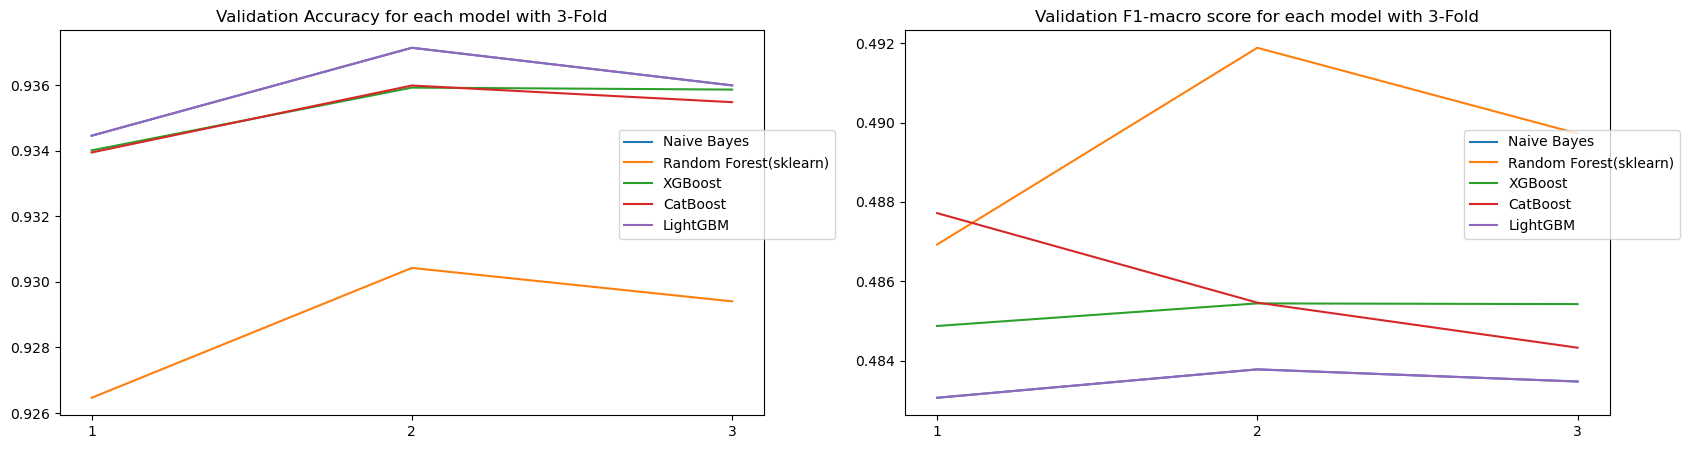

In [24]:
plt.figure(figsize=(20,5))
x = [1,2,3]
plt.subplot(1,2,1)
plt.plot(x,nb_val[0])
plt.plot(x,rfc_sk_val[0])
plt.plot(x,xgb_val[0])
plt.plot(x,cat_val[0])
plt.plot(x,lgbm_val[0])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Validation Accuracy for each model with 3-Fold")

plt.subplot(1,2,2)
plt.plot(x,nb_val[1])
plt.plot(x,rfc_sk_val[1])
plt.plot(x,xgb_val[1])
plt.plot(x,cat_val[1])
plt.plot(x,lgbm_val[1])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Validation F1-macro score for each model with 3-Fold")
plt.show()


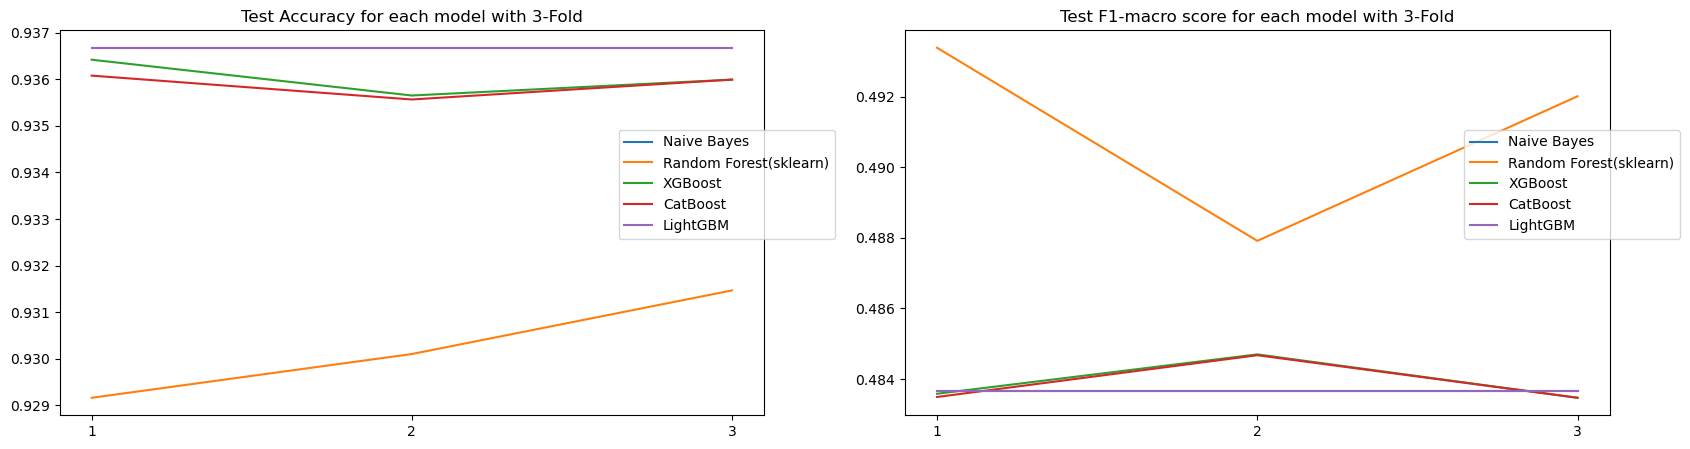

In [25]:
plt.figure(figsize=(20,5))
x = [1,2,3]
plt.subplot(1,2,1)
plt.plot(x,nb_val[2])
plt.plot(x,rfc_sk_val[2])
plt.plot(x,xgb_val[2])
plt.plot(x,cat_val[2])
plt.plot(x,lgbm_val[2])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Test Accuracy for each model with 3-Fold")

plt.subplot(1,2,2)
plt.plot(x,nb_val[3])
plt.plot(x,rfc_sk_val[3])
plt.plot(x,xgb_val[3])
plt.plot(x,cat_val[3])
plt.plot(x,lgbm_val[3])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Test F1-macro score for each model with 3-Fold")
plt.show()

In [26]:
nb_val = cross_validation(nbc,train_feat,train_label,k=5,final_x=test_feat,final_y=test_label)
rfc_sk_val = cross_validation(rfc_sk,train_feat,train_label,k=5,final_x=test_feat,final_y=test_label)
xgb_val = cross_validation(xgb,train_feat,train_label,k=5,final_x=test_feat,final_y=test_label)
cat_val = cross_validation(cat,train_feat,train_label,k=5,final_x=test_feat,final_y=test_label)
lgbm_val = cross_validation(lgbm,train_feat,train_label,k=5,final_x=test_feat,final_y=test_label)

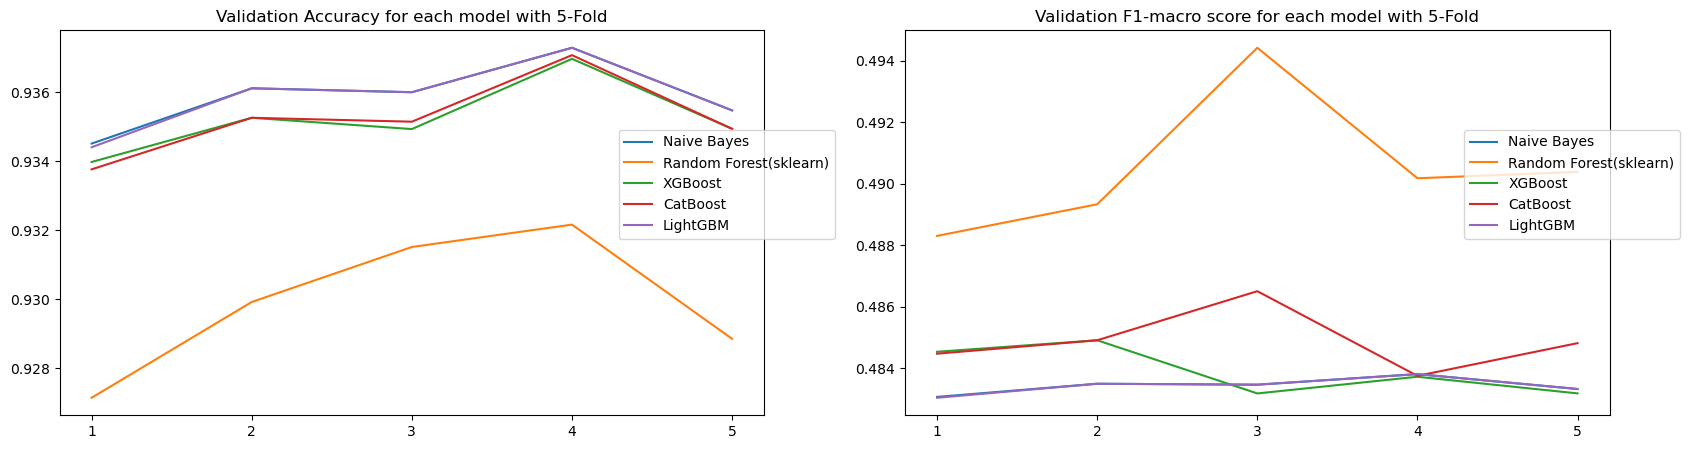

In [27]:
plt.figure(figsize=(20,5))
x = [1,2,3,4,5]
plt.subplot(1,2,1)
plt.plot(x,nb_val[0])
plt.plot(x,rfc_sk_val[0])
plt.plot(x,xgb_val[0])
plt.plot(x,cat_val[0])
plt.plot(x,lgbm_val[0])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Validation Accuracy for each model with 5-Fold")

plt.subplot(1,2,2)
plt.plot(x,nb_val[1])
plt.plot(x,rfc_sk_val[1])
plt.plot(x,xgb_val[1])
plt.plot(x,cat_val[1])
plt.plot(x,lgbm_val[1])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Validation F1-macro score for each model with 5-Fold")
plt.show()


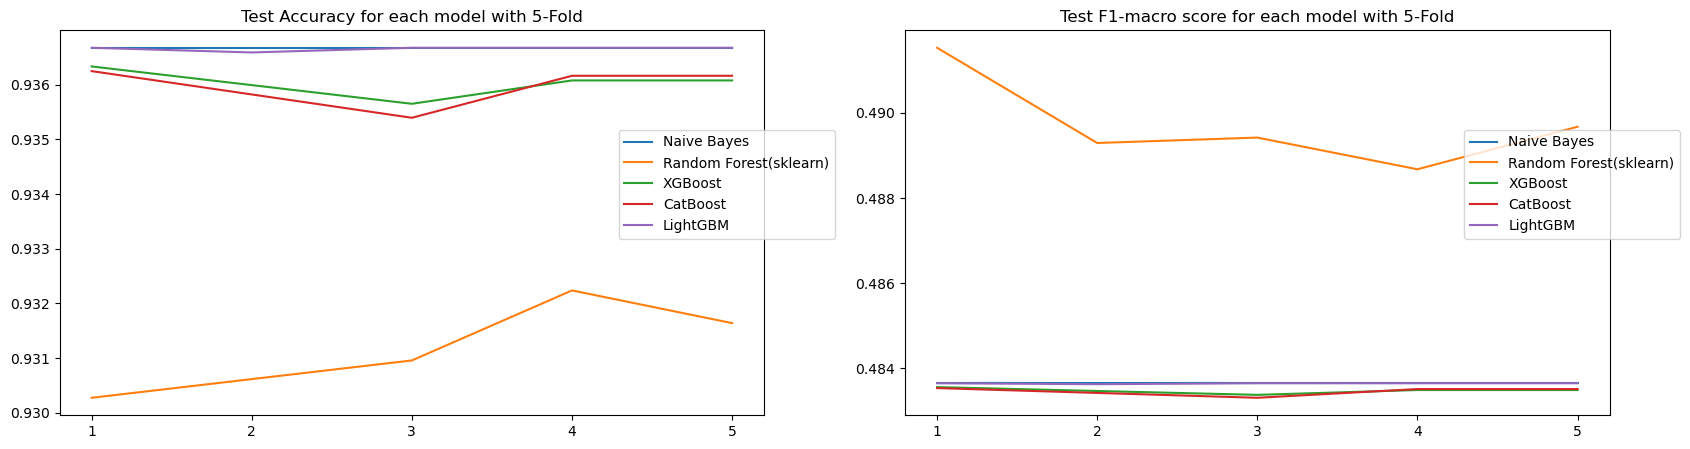

In [28]:
plt.figure(figsize=(20,5))
x = [1,2,3,4,5]
plt.subplot(1,2,1)
plt.plot(x,nb_val[2])
plt.plot(x,rfc_sk_val[2])
plt.plot(x,xgb_val[2])
plt.plot(x,cat_val[2])
plt.plot(x,lgbm_val[2])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Test Accuracy for each model with 5-Fold")

plt.subplot(1,2,2)
plt.plot(x,nb_val[3])
plt.plot(x,rfc_sk_val[3])
plt.plot(x,xgb_val[3])
plt.plot(x,cat_val[3])
plt.plot(x,lgbm_val[3])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Test F1-macro score for each model with 5-Fold")
plt.show()

In [29]:
nb_val = cross_validation(nbc,train_feat,train_label,k=10,final_x=test_feat,final_y=test_label)
rfc_sk_val = cross_validation(rfc_sk,train_feat,train_label,k=10,final_x=test_feat,final_y=test_label)
xgb_val = cross_validation(xgb,train_feat,train_label,k=10,final_x=test_feat,final_y=test_label)
cat_val = cross_validation(cat,train_feat,train_label,k=10,final_x=test_feat,final_y=test_label)
lgbm_val = cross_validation(lgbm,train_feat,train_label,k=10,final_x=test_feat,final_y=test_label)

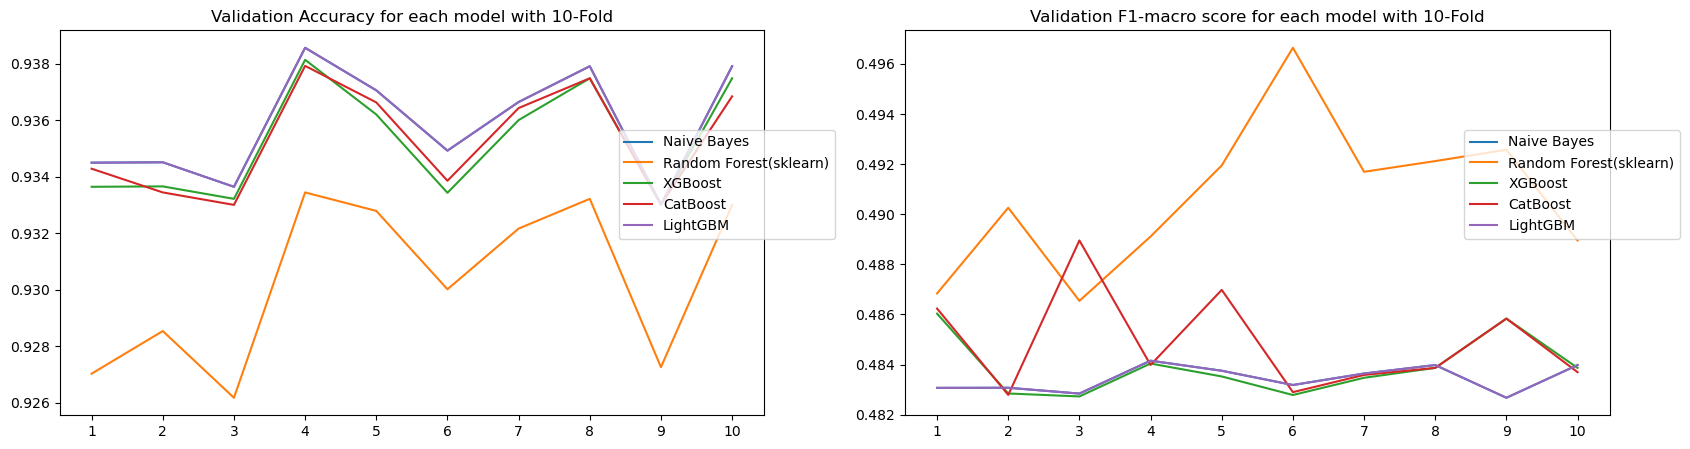

In [30]:
plt.figure(figsize=(20,5))
x = [1,2,3,4,5,6,7,8,9,10]
plt.subplot(1,2,1)
plt.plot(x,nb_val[0])
plt.plot(x,rfc_sk_val[0])
plt.plot(x,xgb_val[0])
plt.plot(x,cat_val[0])
plt.plot(x,lgbm_val[0])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Validation Accuracy for each model with 10-Fold")

plt.subplot(1,2,2)
plt.plot(x,nb_val[1])
plt.plot(x,rfc_sk_val[1])
plt.plot(x,xgb_val[1])
plt.plot(x,cat_val[1])
plt.plot(x,lgbm_val[1])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Validation F1-macro score for each model with 10-Fold")
plt.show()

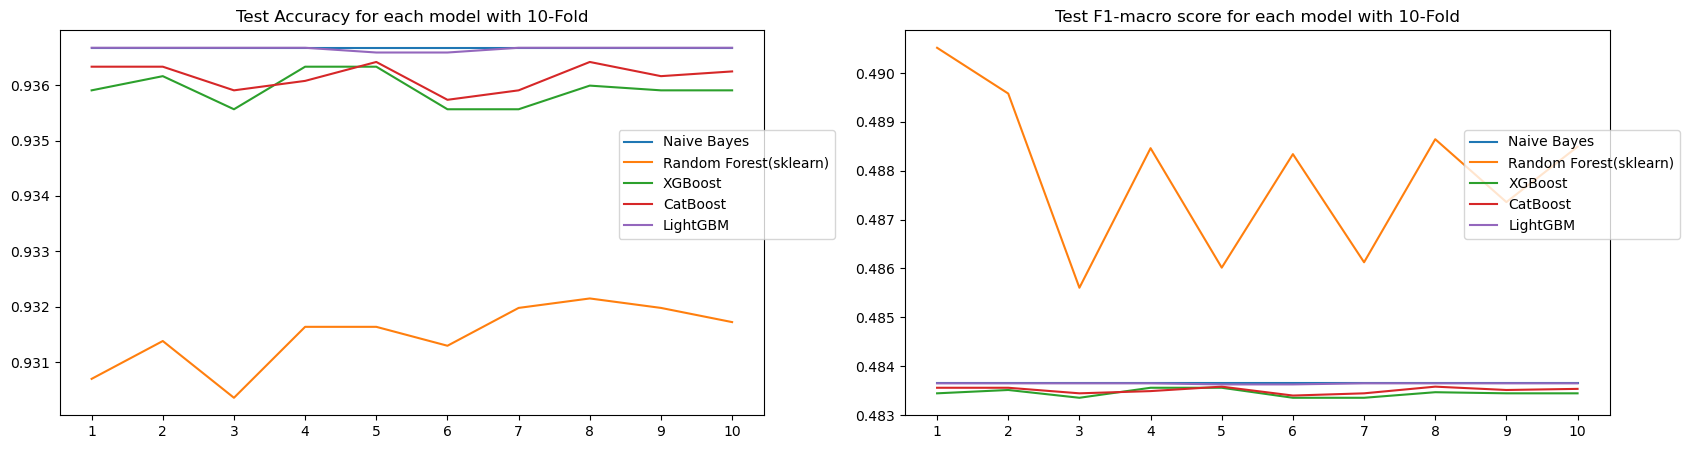

In [31]:
plt.figure(figsize=(20,5))
x = [1,2,3,4,5,6,7,8,9,10]
plt.subplot(1,2,1)
plt.plot(x,nb_val[2])
plt.plot(x,rfc_sk_val[2])
plt.plot(x,xgb_val[2])
plt.plot(x,cat_val[2])
plt.plot(x,lgbm_val[2])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Test Accuracy for each model with 10-Fold")

plt.subplot(1,2,2)
plt.plot(x,nb_val[3])
plt.plot(x,rfc_sk_val[3])
plt.plot(x,xgb_val[3])
plt.plot(x,cat_val[3])
plt.plot(x,lgbm_val[3])
plt.xticks(range(1, len(x) + 1))
plt.legend(["Naive Bayes","Random Forest(sklearn)","XGBoost","CatBoost","LightGBM"],bbox_to_anchor = (1.11, 0.6), loc='center right')
plt.title("Test F1-macro score for each model with 10-Fold")
plt.show()